In [1]:
# %conda install tqdm==4.66.5 scipy==1.13.1 plotly==5.24.1 numpy==1.26.4 pandas==2.2.2 openblas==0.3.21 matplotlib==3.9.2

In [2]:
import numpy as np
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import norm, multivariate_normal, uniform, beta

from samplers import hmc, metro_hastings, R_hat, plot_chains, param_scatter

n_iters = 3000
warmup = 1000
p = 3
n_param = p + 1

Markov Chain Monte Carlo (MCMC) algorithms draw samples from target probability distributions. The resulting samples can be used to approximate integrals (i.e. expectations) over the distribution being targeted. They are the workhorse of Bayesian computation, where posteriors are often too complex to solve without algorithmic tools, and are responsible for computation in the popular Bayesian software packages Stan and PyMC. 

I use PyMC fairly regularly, but my understanding of the MCMC algo it uses (a variant of HMC) was largely based on intuition. The analyses in the notebooks in this folder (`Portfolio/MCMC/`) are part of a self learning exercise where I use an implementation of Hamiltonian Monte Carlo (HMC) that I built in order to better understand how this class of algorithms works.

The HMC algorithm is based on the exposition in [Gelman et al.](https://stat.columbia.edu/~gelman/book/) chapters 10, 11, and 12. The MCMC functions live in `samplers/samplers.py`. There are some MCMC diagnostics in `samplers/utils.py`

The `hmc` function is a Hamiltonian Monte Carlo (HMC) sampler.  It requires 
- `log_prob`: an unnormed log probability for the distribution of interest, 
- `data`: a dictionary of data and parameters to pass to that log_prob. This is evaluated as part of each iteration of the algorithm
- `grad`: the gradient of the distribution with regard to the parameters and a starting point for the parameter samples. 
- `n_iters`: the number of iterations for the algorithm
- `starting`: a starting point for the samples
- `eps`, `L`, `M`: Tuning parameters for the algorithms Hamiltonian dynamics. See [Gelman et al.](https://stat.columbia.edu/~gelman/book/) chapter 12.

The algorithm generates a "momentum" variable at the start of each iteration. It uses this and the gradient to explore the target log density through a discrete approximation to hamiltonian dynamics in physics. At the end of an iteration, it computes a ratio $r$ of the target density at the starting values and the final location of the iteration. It accepts the new location as a sample with probability $\min(r,1)$ - this is the same as the Metropolis Hastings algorithm's acceptance step. This means that normalisation constants cancel and we can work with unnormalised log densities as our target algorithm. 

At the end of the interations, we have a "chain" of samples. A properly-tuned HMC run will converge to the target density, but that convergence takes time, so we drop a fixed number of starting iterations as a "warmup". Convergence to the target density can be measured by visual and diagnostic tests that I discuss later.

## Sampling From a Beta Distribution

To see how it works, imagine we want to use it to draw samples from a Beta(x\|a = 3,b = 5) distribution. We would never use MCMC for this in practice, because simpler methods like the ratio of gamma variables exist for Beta sampling, but it is a nice example of how these algorithms work.

The algorithm works best if its sample space is unbounded so the search doesn't reach areas of zero density. I use the logistic function to achieve this by mapping the real line to the support of the Beta distribution. The details of the derivation are in a footnote [^1] 

In [3]:
def inv_logit(x):
    return 1 / (1 + np.exp(-x))


def log_prob_beta(proposal, a, b):
    x = inv_logit(proposal)
    return (
        (a - 1) * np.log(x)
        + (b - 1) * np.log(1 - x)
        - proposal
        - 2 * np.log(1 + np.exp(-proposal))
    )


def grad_beta(proposal, a, b):
    inv_lgt_grad = 1 / (1 + np.exp(-proposal)) ** 2 * np.exp(-proposal)
    x = inv_logit(proposal)
    return (
        ((a - 1) / x - (b - 1) / (1 - x)) * inv_lgt_grad
        - 1
        + 2 * np.exp(-proposal) / (1 + np.exp(-proposal))
    )


samples = hmc(
    M=1.0,
    data={"a": 5, "b": 3},
    grad=grad_beta,
    n_iter=n_iters,
    log_prob=log_prob_beta,
    starting=[0],
    eps=0.01,
    L=100,
)

accept rate: 1.0: 100%|████████████████████| 2999/2999 [00:13<00:00, 221.83it/s]


This results in the following chain of samples. The top plot is the untransformed variable. The lower plot is the inverse logit transformed variable. We can see that it's mapped to $[0,1]$ and concentrating around the top part of the interval

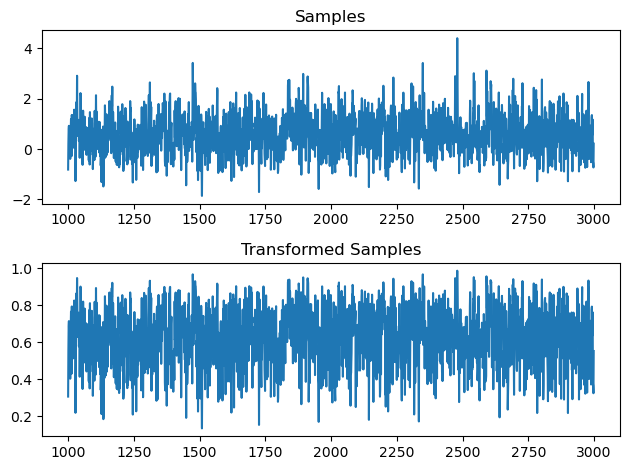

In [4]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(range(warmup, n_iters), samples[warmup:])
ax[0].set_title("Samples")
ax[1].plot(range(warmup, n_iters), inv_logit(samples[warmup:]))
ax[1].set_title("Transformed Samples")
fig.tight_layout();

The sample mean is close to the true mean of 0.625. The quantiles and histogram of the samples are also in accordance with the expected shape.

In [5]:
print(f"sample mean {inv_logit(samples[warmup:]).mean()}, true mean {5/8}")
print(
    f"true .25, .5 and .75 quantiles {np.round((beta(5,3).ppf(.25),beta(5,3).ppf(.5), beta(5,3).ppf(.75)),3)}"
)
print(
    f"sample .25, .5 and .75 quantiles {np.round(np.quantile(inv_logit(samples[warmup:]), (.25, .5, .75)),3)}"
)

sample mean 0.6260087623572026, true mean 0.625
true .25, .5 and .75 quantiles [0.514 0.636 0.747]
sample .25, .5 and .75 quantiles [0.516 0.636 0.747]


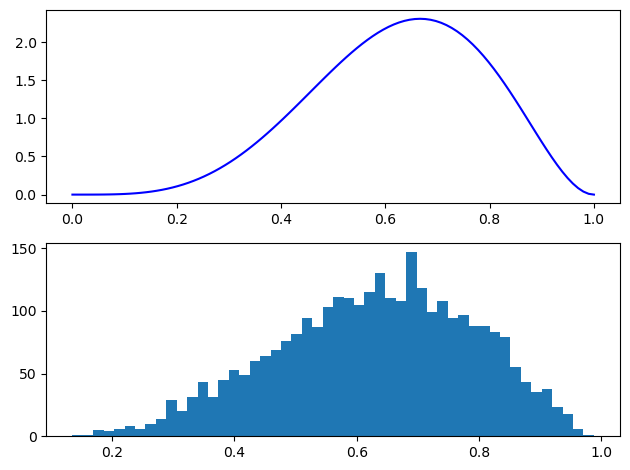

In [6]:
x = np.linspace(0, 1, 100)

fig, ax = plt.subplots(2, 1)

ax[0].plot(x, beta(5, 3).pdf(x), c="blue")

ax[1].hist(inv_logit(samples), 50)

fig.tight_layout();

## Linear Regression

This is a model for a linear regression with gaussian errors, an inverse gamma prior $\mathrm{inv\_\Gamma}(1.5, 1)$ on the standard deviation of the errors and independent normal priors on the coefficients of the model.

Using $X_{i\cdot}$ as the $i^{th}$ row of X, the matrix of predictors, and $\mathbf{y}$ as the vector of outcome observations. The posterior density is
$$p(\theta|\mathbf{y}) \propto \prod_{i=1}^{N}\frac{1}{\sigma^2} \exp \left(\frac{-(y_i - X_{i\cdot}\beta)^2}{2\sigma^2}\right) \frac{1}{\sigma^5}\exp\left({\frac{-1}{\sigma^2}}\right)\exp\left(\frac{-\beta^T\beta}{2}\right)$$

The gradient for the _log_ posterior for the coefficients is 

$$\sum_{i=1}^{N}\left[\frac{\left(y_i - X_{i\cdot}\beta\right)}{\sigma^2} X_{i\cdot}\right] - \beta^T$$

The partial derivative for sigma is 

$$ -5 - \frac{2(N-1)}{\sigma^2} + \sum_{i=1}^{N}\frac{y_i - X_{i\cdot}\beta}{\sigma^3} $$

In [7]:
def log_prob(data, X, proposal):
    mu = X @ proposal[:-1]
    sigma = proposal[-1]  # variance

    log_lik = np.sum(-((data - mu) ** 2) / (2 * sigma**2)) - data.shape[0] * np.log(
        sigma**2
    )

    prior_coef = -np.dot(proposal.T, proposal) / 2
    prior_sigma = -2.5 * np.log(sigma**2) - 1 / sigma**2

    return log_lik + prior_coef + prior_sigma


def grad(data, X, proposal):
    mu = X @ proposal[:-1, :]
    sigma = proposal[-1, :]
    N = data.shape[0]

    coef_grad = (
        np.sum((data - mu) / (sigma**2) * X, axis=0).reshape(-1, 1) - proposal[:-1]
    )

    sigma_grad = [
        -5.0 - 2 * (N - 1) / (sigma**2) + np.sum((data - mu) ** 2 / (sigma**3))
    ]
    # print(sigma_grad)
    return np.r_[coef_grad, sigma_grad]


def create_regression(N=1000, p=2, sigma=2):
    coef = uniform(-2, 4).rvs(p)

    X = multivariate_normal(np.zeros(p), np.eye(p, p)).rvs(N)

    y = X @ coef + norm(0, sigma).rvs(N)
    y = y.reshape(-1, 1)
    coef = coef.reshape(-1, 1)
    return X, y, coef, sigma


X, y, coef, sigma = create_regression(N=1000, p=p)

In [8]:
print(f"coefficients = {coef.flatten()}, sigma = {sigma}")

coefficients = [-0.99171059 -1.51395354  0.1557642 ], sigma = 2


### Sampling the posterior and checking convergence

To check that our setup converges to the desired distribution, we run the sampler 4 times. Each sampler "chain" starts from different - ideally well separated - starting points. This is tricky to set up because if our starting points are too diffuse, the algorithm will take a long time to converge. If our starting points are all together, we run the risk of getting stuck in a local maximum. To check that we have converged, we want our runs to end up in the same region of posterior space. We can check this by visual inspection and the calculation of the $\hat{R}$ value, which is a ratio of between chain and within chain variance that will converge to 1 if the chains have mixed in the same region of posterior space.

In [9]:
chains = np.ones([4, n_iters, coef.shape[0] + 1])

for chain in range(chains.shape[0]):
    params = hmc(
        M=np.eye(n_param, n_param) * 1.2,
        data={"data": y, "X": X},
        grad=grad,
        n_iter=n_iters,
        log_prob=log_prob,
        starting=np.r_[
            np.random.choice(y.flatten(), size=p, replace=False),
            np.exp(norm(0, 0.5).rvs(1)),
        ],
        eps=0.01,
        L=100,
    )
    chains[chain, :, :] = params

accept rate: 1.0: 100%|████████████████████| 2999/2999 [00:25<00:00, 118.53it/s]


The $\hat{R}$ diagnostic value (the ratio of between and within chain variance) is less than 1.1 for all variables, and the chains appear to cover the same area in the plots, indicating that we have converged to the target distribution.

In [10]:
R_hat(chains, warmup).round(3)

array([1., 1., 1., 1.])

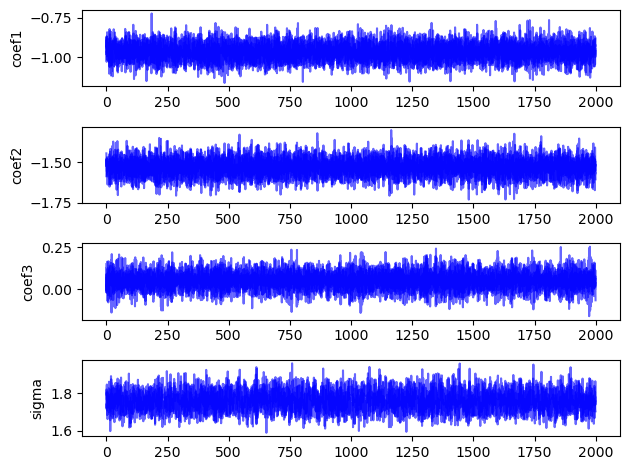

In [11]:
plot_chains(chains, warmup, names=["coef1", "coef2", "coef3", "sigma"])

Another way to check for issues with our chains is to plot scatterplots of pairs of our variables. There are no obvious degeneracies in the plots below.

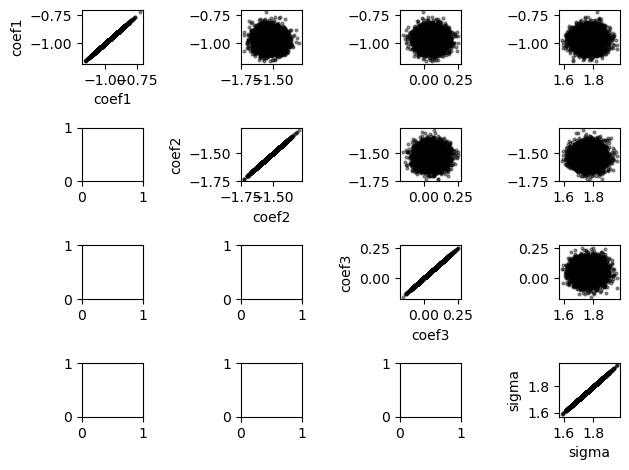

In [12]:
samples = chains[:, warmup:, :].reshape(4 * (n_iters - warmup), n_param)

param_scatter(
    samples,
    warmup=0,
    names=["coef1", "coef2", "coef3", "sigma"],
    plot_params={"alpha": 0.4, "s": 4, "c": "k"},
)

## Computing things we care about
Using these samples we can estimate the expection of whatever function of the samples that we like. First, we need to drop the warmup samples and eliminate the chain dimension from our chains variable. We did this above when creating `params`.

Firstly, we We can see that the sample means are close to the true values. 

In [13]:
print(f"Sample means for each parameter {samples.mean(axis=0)}")
print(f"True values for each parameter {np.r_[coef.flatten(), [sigma]]}")

Sample means for each parameter [-0.96534396 -1.52982     0.05237238  1.75990307]
True values for each parameter [-0.99171059 -1.51395354  0.1557642   2.        ]


We can also compute more interesting summaries. Firstly, the 90% quantiles of the marginal distributions. 

In [14]:
q = np.quantile(samples, (0.025, 0.975), axis=0).round(3)
names = ["coef1", "coef2", "coef3", "sigma"]
for i in range(p + 1):
    print(
        f"There is a 90% probability that {names[i]} has a value between {q[0, i]} and {q[1,i]}"
    )

There is a 90% probability that coef1 has a value between -1.071 and -0.858
There is a 90% probability that coef2 has a value between -1.637 and -1.422
There is a 90% probability that coef3 has a value between -0.054 and 0.158
There is a 90% probability that sigma has a value between 1.664 and 1.865


If we want to know the probability that the second variable is more important than the other two variables for our outcome, then this is as simple as taking a mean over an indicator of the relationship we are interested in.

In [15]:
p_indicator = np.mean(
    (samples[:, 1] > samples[:, 0]) & (samples[:, 1] > samples[:, 2])
).round(3)
print(
    f"The probability that the second variable has a larger effect on our outcome than the others is {p_indicator}"
)

The probability that the second variable has a larger effect on our outcome than the others is 0.0


We can compute realisations from the distributions indexed by our samples for each observation - the "posterior predictive distribution" - and compare our observations to the resulting distributions. This allows us to plot the histograms of the distributions and a tail p-value  for each observation . In the plots below I plot the difference between the predictions and the observation corresponding to them, so 0 is the true value. Very low or very high p-values are cause for concern, but this is a moot point here because the model corresponds perfectly to the data generating process. 

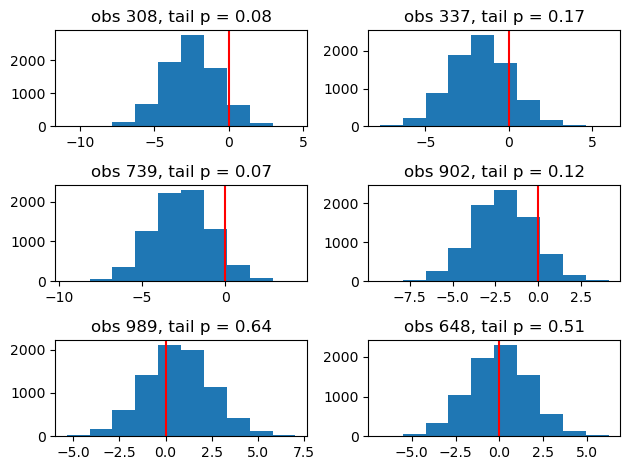

In [16]:
posterior_mu = X @ samples[:, :-1].T
posterior_sigma = samples[:, -1]
post_preds = norm(posterior_mu, posterior_sigma).rvs((1000, samples.shape[0]))

post_pred_errors = post_preds - y.reshape(-1, 1)

rand_obs = np.random.choice(range(y.shape[0]), 6, replace=False)

fig, ax = plt.subplots(3, 2)

for i, obs in enumerate(rand_obs):
    # print(f"i {i} row {(i)//2 + 1} , col {(i) % 2 }")

    ax[i // 2, i % 2].hist(x=post_pred_errors[obs])

    ax[i // 2, i % 2].axvline(x=0, c="r")
    ax[i // 2, i % 2].set_title(
        f"obs {obs}, tail p = {np.mean(post_pred_errors[obs] > 0).round(2)}"
    )

fig.tight_layout();

### Footnotes

[^1]: The density for the logit $y$ of the Beta variable is 

$$f(y|a,b) = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}l(y)^{a-1}(1-l(y))^{b-1}l(y)^2\exp(-y)$$

Where $l$ is the inverse logit function

$$l(x) =  \frac{1}{1+\exp(-x)} $$

The distribution's normalisation constant by definition doesn't depend on $x$ and we can ignore it for the purposes of the algorithm, so we use the unnormalised log density for the Beta distribution

$$ f(y, a, b) = (a-1) \dot \log\left[l(y)\right] + (b-1) \dot \log\left[1-l(y)\right] - y - 2\log\left[1+\exp(-y)\right]$$




so $l(x) \in [0,1]$.

We need the derivative for this function in order to use HMC. It is 

$$\frac{\partial f(y|a,b)}{\partial y} = \left(\frac{a-1}{l(y)} - \frac{b-1}{1-l(y)}\right) l(y)^2 \exp(-y) - 1 + 2l(y)\exp(-y)$$